# Load and preprocess DVS input for SNN

In [1]:
% matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from snntoolbox.config import settings as s

In [112]:
def remove_outliers(timestamps, xaddr, yaddr, pol, x_max=239, y_max=179):
    len_orig = len(timestamps)
    xaddr_valid = np.where(np.array(xaddr) <= x_max)
    yaddr_valid = np.where(np.array(yaddr) <= y_max)
    xy_valid = np.intersect1d(xaddr_valid[0], yaddr_valid[0], True)
    xaddr = np.array(xaddr)[xy_valid]
    yaddr = np.array(yaddr)[xy_valid]
    timestamps = np.array(timestamps)[xy_valid]
    pol = np.array(pol)[xy_valid]
    num_outliers = len_orig - len(timestamps)
    if num_outliers:
        print("Removed {} outliers.".format(num_outliers))
    return timestamps, xaddr, yaddr, pol


def load_dvs_sequence(filename, xyrange=None):

    from snntoolbox.io_utils.AedatTools import ImportAedat
    
    print("Loading DVS sample {}...".format(filename))
    events = ImportAedat.import_aedat({'filePathAndName': filename})['data']['polarity']

    timestamps = events['timeStamp']
    xaddr = events['x']
    yaddr = events['y']
    pol = events['polarity']

    # Remove events with addresses outside valid range
    if xyrange:
        timestamps, xaddr, yaddr, pol = remove_outliers(
            timestamps, xaddr, yaddr, pol, xyrange[0], xyrange[1])

    xaddr = xyrange[0] - xaddr
    yaddr = xyrange[1] - yaddr

    return xaddr, yaddr, timestamps


def extract_batch(xaddr, yaddr, timestamps, batch_size, batch_idx=0, num_events_per_sample=2000, scale=(239/63, 179/63)):
    from snntoolbox.io_utils.common import to_categorical
    from collections import deque

    x_b_xaddr = [deque() for _ in range(batch_size)]
    x_b_yaddr = [deque() for _ in range(batch_size)]
    x_b_ts = [deque() for _ in range(batch_size)]
    for sample_idx in range(batch_size):
        start_event = num_events_per_sample * batch_size * batch_idx + \
                      num_events_per_sample * sample_idx
        event_idxs = range(start_event,
                           start_event + num_events_per_sample)
        event_sums = np.zeros((64, 64), 'int32')
        xaddr_sub = []
        yaddr_sub = []
        for x, y in zip(xaddr[event_idxs], yaddr[event_idxs]):
            if scale:
                # Subsample from 240x180 to e.g. 64x64
                x = int(x / scale[0])
                y = int(y / scale[1])
            event_sums[y, x] += 1
            xaddr_sub.append(x)
            yaddr_sub.append(y)
        sigma = np.std(event_sums)
        # Clip number of events per pixel to three-sigma
        np.clip(event_sums, 0, 3*sigma, event_sums)
        print("Discarded {} events during 3-sigma standardization.".format(
            num_events_per_sample - np.sum(event_sums)))
        ts_sample = timestamps[event_idxs]
        for x, y, ts in zip(xaddr_sub, yaddr_sub, ts_sample):
            if event_sums[y, x] > 0:
                x_b_xaddr[sample_idx].append(x)
                x_b_yaddr[sample_idx].append(y)
                x_b_ts[sample_idx].append(ts)
                event_sums[y, x] -= 1

    label = None
    for key, value in label_dict.items():
        if value in filename:
            label = key

    # Each sample in the batch has the same label because it is generated
    # from the same DVS sequence.
    y_b = np.broadcast_to(to_categorical([label], 4), (batch_size, 4))

    return x_b_xaddr, x_b_yaddr, x_b_ts, y_b


def get_event_frames(xaddr, yaddr, timestamps, frame_width=1000):
    inp = []
    while len(xaddr) > 0:
        bin_map = np.zeros((64, 64))
        # Buffer event sequence because we will be removing
        # elements from original list:
        xaddr_sample = list(xaddr)
        yaddr_sample = list(yaddr)
        ts_sample = list(timestamps)
        first_ts_of_frame = ts_sample[0] if ts_sample else 0
        for x, y, ts in zip(xaddr_sample, yaddr_sample, ts_sample):
            if bin_map[y, x] == 0:
                bin_map[y, x] = 1
                # Can't use .popleft()
                xaddr.remove(x)
                yaddr.remove(y)
                timestamps.remove(ts)
            if ts - first_ts_of_frame > frame_width:
                break
        inp.append(bin_map)
    return np.stack(inp, -1)

## Load DVS sequences

In [114]:
path = '/home/rbodo/.snntoolbox/Datasets/roshambo/DVS_all/paper'
filename = sorted(os.listdir(path))[7]
filepath = os.path.join(path, filename)
label_dict = {'0': 'paper', '1': 'scissors', '2': 'rock', '3': 'background'}
xaddr_all, yaddr_all, timestamps_all = load_dvs_sequence(filepath, (239, 179))
x_b_xaddr, x_b_yaddr, x_b_ts, y_b = extract_batch(xaddr_all, yaddr_all, timestamps_all, 20, 0, 2000)

Loading DVS sample /home/rbodo/.snntoolbox/Datasets/roshambo/DVS_all/paper/paper_enea_back.aedat...


Discarded 483 events during 3-sigma standardization.
Discarded 445 events during 3-sigma standardization.
Discarded 430 events during 3-sigma standardization.
Discarded 485 events during 3-sigma standardization.
Discarded 486 events during 3-sigma standardization.
Discarded 568 events during 3-sigma standardization.
Discarded 563 events during 3-sigma standardization.
Discarded 581 events during 3-sigma standardization.
Discarded 551 events during 3-sigma standardization.
Discarded 524 events during 3-sigma standardization.
Discarded 478 events during 3-sigma standardization.


Discarded 510 events during 3-sigma standardization.
Discarded 486 events during 3-sigma standardization.
Discarded 470 events during 3-sigma standardization.
Discarded 439 events during 3-sigma standardization.
Discarded 614 events during 3-sigma standardization.
Discarded 592 events during 3-sigma standardization.
Discarded 485 events during 3-sigma standardization.
Discarded 462 events during 3-sigma standardization.
Discarded 492 events during 3-sigma standardization.


## Plot an "event-frame" consisting of 1000 events

(0, 179)

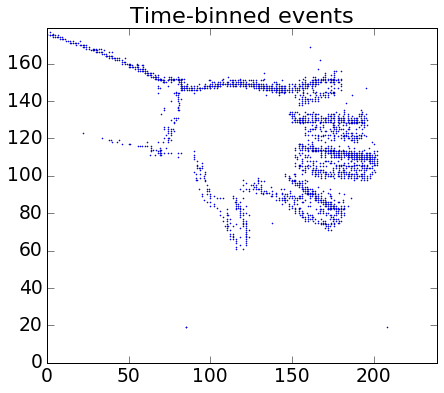

In [115]:
frame_idx = 1
width = 2000
plt.scatter(xaddr_all[frame_idx*width:(frame_idx+1)*width], yaddr_all[frame_idx*width:(frame_idx+1)*width], s=2, linewidths=0.1)
plt.title('Time-binned events')
plt.xlim(0, 239)
plt.ylim(0, 179)

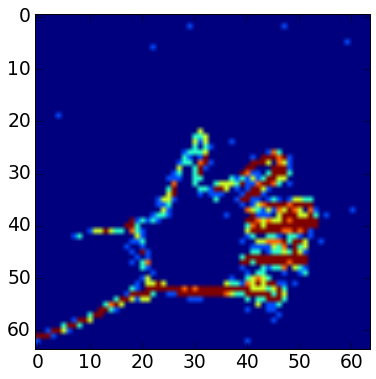

In [116]:
frame_idx = 0
img = np.zeros((64, 64))
for x, y in zip(x_b_xaddr[frame_idx], x_b_yaddr[frame_idx]):
    img[y, x] += 1
plt.imshow(img)

In [98]:
frame_width = 1000
xaddr_sample = x_b_xaddr[0].copy()
yaddr_sample = x_b_yaddr[0].copy()
timestamps_sample = x_b_ts[0].copy()
inp = get_event_frames(xaddr_sample, yaddr_sample, timestamps_sample, frame_width)
num_frames = inp.shape[-1]
print("Generated {} binary event maps.".format(num_frames))

Generated 19 binary event maps.


IndexError: index 19 is out of bounds for axis 2 with size 19

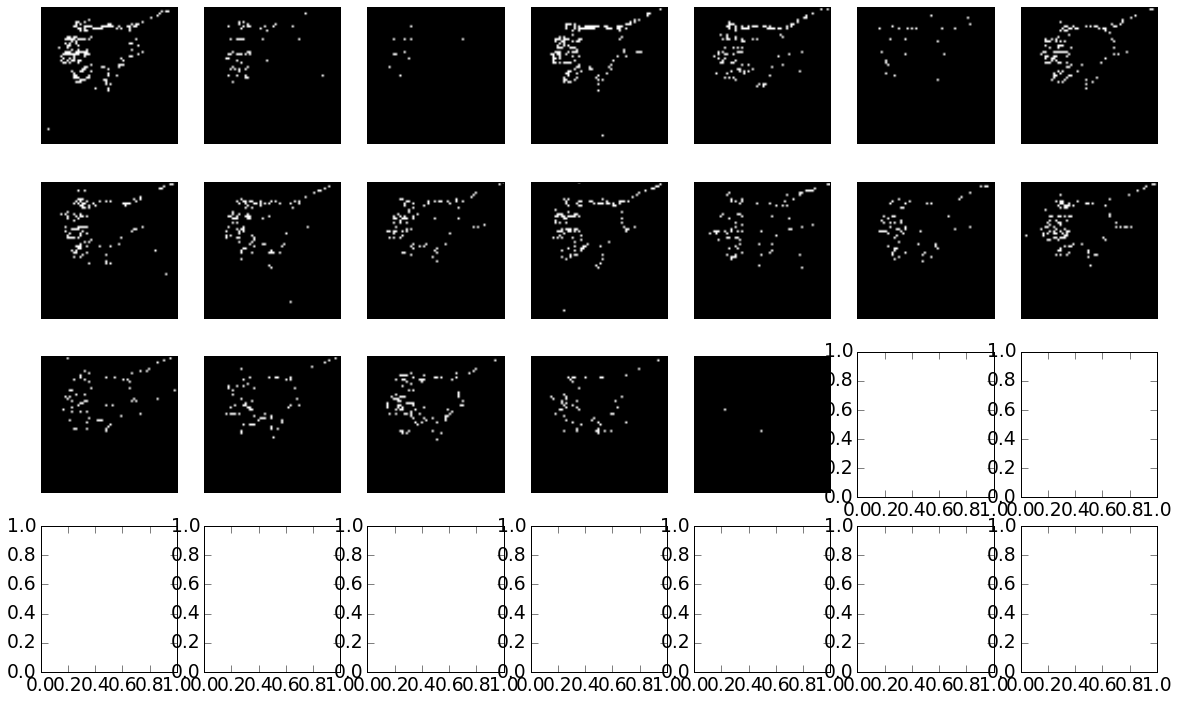

In [99]:
nrows = 4
ncols = 7
fig = plt.figure(figsize=(20, 12))
axes = [fig.add_subplot(nrows, ncols, 1 + r * ncols + c) for r in range(nrows) for c in range(ncols)]

for i, ax in enumerate(axes):
    ax.imshow(inp[..., i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

## Plot accumulation of all events

In [8]:
plt.scatter(xaddr_all, yaddr_all, s=2, linewidths=0.1)
plt.title('Accumulated event sequence')
plt.xlim(0, None)
plt.ylim(0, None)

(0, 200.0)

## Plot timestamps of event sequence

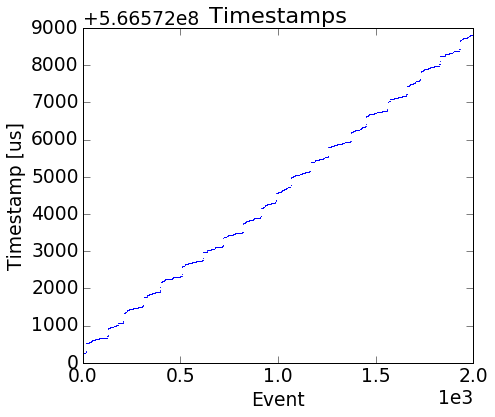

In [10]:
plt.plot(timestamps_all[2000:4000], '.', markersize=1)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.title('Timestamps')
plt.xlabel('Event')
plt.ylabel('Timestamp [us]')

## Compare different sub-sampling techniques

In [141]:
from PIL import Image

x_test_sub1 = []
x_test_full = []  # Not downsampled
snapshot_durations = []
# Loop over all samples
for x_list, y_list, ts_list in zip(xaddr_all, yaddr_all, timestamps_all):
    # Snapshot with at most one event per pixel
    inp_shallow = np.zeros((180, 240))
    # List of snapshots
    inp_t = []
    inp_t_full = []  # not downsampled
    # List of latest timestamps per snapshot
    inp_ts = []
    # Loop over all events of sample
    for e_x, e_y, e_ts in zip(x_list, y_list, ts_list):
        if inp_shallow[e_y, e_x] == 0:
            inp_shallow[e_y, e_x] += 1
        else:
            # Downsample snapshot and add it to the others
            inp_downsampled = np.array(Image.fromarray(inp_shallow).resize((64, 64)), ndmin=3)
            inp_t.append(inp_downsampled)
            inp_t_full.append(inp_shallow)
            inp_ts.append(e_ts)
            # Start new snapshot
            inp_shallow = np.zeros((180, 240))
    x_test_sub1.append(np.array(inp_t, 'float32'))
    x_test_full.append(np.array(inp_t_full, 'float32'))
    snapshot_durations.append(np.diff(inp_ts))

In [142]:
from skimage.measure import block_reduce
x_test_sub2 = []
x_test_sub3 = []
for sample in x_test_full:
    x_test_sub2.append(np.pad(block_reduce(sample, (1, 3, 4), np.max), ((0, 0), (2, 2), (2, 2)), 'constant', constant_values=0))
    x_test_sub3.append(np.pad(block_reduce(sample, (1, 3, 4), np.sum), ((0, 0), (2, 2), (2, 2)), 'constant', constant_values=0))

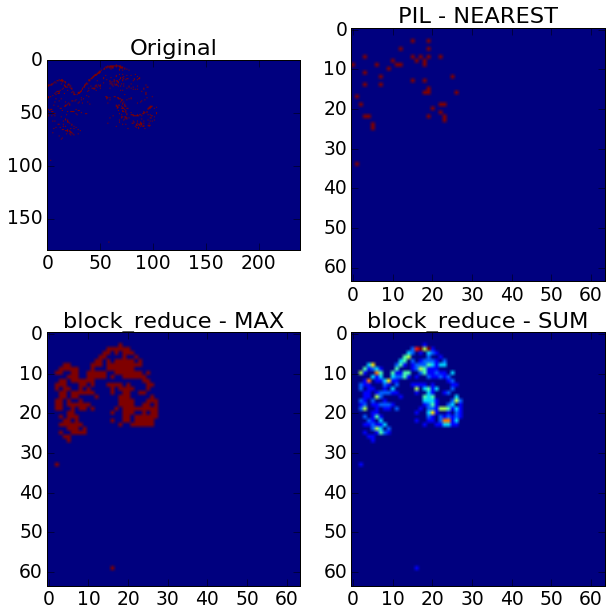

In [146]:
sample_idx = 0
snapshot_idx = 5000

f, ax = plt.subplots(2, 2)
f.set_figwidth(10)
f.set_figheight(10)
ax[0, 0].imshow(np.squeeze(x_test_full[sample_idx][snapshot_idx]))
ax[0, 1].imshow(np.squeeze(x_test_sub1[sample_idx][snapshot_idx]))
ax[1, 0].imshow(np.squeeze(x_test_sub2[sample_idx][snapshot_idx]))
ax[1, 1].imshow(np.squeeze(x_test_sub3[sample_idx][snapshot_idx]))
ax[0, 0].set_title("Original")
ax[0, 1].set_title("PIL - NEAREST")
ax[1, 0].set_title("block_reduce - MAX")
ax[1, 1].set_title("block_reduce - SUM")